## Police Crime & City Survey EDA and Data Preprocessing

In [377]:
#import packages
import pandas as pd
import numpy as np
import urllib.request
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import reverse_geocoder as rg
import pprint
import geocoder
import multiprocessing as mp
import geopy
from geopy.geocoders import Nominatim
from geopy.point import Point
!pip install geopandas
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingRegressor

1. Load in Data

In [10]:
xls = pd.ExcelFile('City Survey Master Data 1996-2019.xlsx')
city_df = pd.read_excel(xls, 'Historical Data')
police_df1318 = pd.read_csv("PoliceDepartment_IncidentReports_2003_May2018.csv")
police_df_18 = pd.read_csv("Police_Department_Incident_Reports__2018_to_Present.csv")

2. Police Crime [EDA & Preprocessing]
- 2013-2018: https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry 
- 2018-Present: https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783

In [145]:
#create geometry columns --> later extract zipcode
police_df_18['geometry'] = police_df_18['Point']
police_df1318['geometry'] = police_df1318['location']

#drop unneeded columns
police_df13 = police_df1318.drop(columns=['DELETE - 2017 Fix It Zones 2 2', 'Civic Center Harm Reduction Project Boundary 2 2',
                                    'Fix It Zones as of 2017-11-06  2 2', 'DELETE - HSOC Zones 2 2', "location",
                                     'Fix It Zones as of 2018-02-07 2 2', 'CBD, BID and GBD Boundaries as of 2017 2 2', 
                                     'Central Market/Tenderloin Boundary 2 2', 'Central Market/Tenderloin Boundary Polygon - Updated 2 2',
                                    'HSOC Zones as of 2018-06-05 2 2', 'OWED Public Spaces 2 2', 'DELETE - Fire Prevention Districts 2 2','DELETE - Police Districts 2 2',
                                      'DELETE - Supervisor Districts 2 2','DELETE - Zip Codes 2 2','DELETE - Neighborhoods 2 2',
                                     'SF Find Neighborhoods 2 2', 'Current Police Districts 2 2','Time',
                                      'Current Supervisor Districts 2 2','Analysis Neighborhoods 2 2', 'DayOfWeek', 'Resolution',
                                      'Areas of Vulnerability, 2016 2 2','Neighborhoods 2', 'Incident Code', 'Descript'])


police_df18 = police_df_18.drop(columns=['Report Datetime', 'Row ID','Incident Subcategory', 'Incident Description',
        'Resolution', 'Intersection', 'CNN', 
        'Analysis Neighborhood', 'Supervisor District','Point',
        'Supervisor District 2012', 'CAD Number',
        'Report Type Code', 'Report Type Description', 'Filed Online',
        'Incident Code',
        'Neighborhoods', 'ESNCAG - Boundary File',
        'Central Market/Tenderloin Boundary Polygon - Updated','Incident Day of Week', 
        'Civic Center Harm Reduction Project Boundary', 'Incident Date', 'Incident Time', 'Incident Year',
        'HSOC Zones as of 2018-06-05', 'Invest In Neighborhoods (IIN) Areas',
        'Current Supervisor Districts', 'Current Police Districts'])
police_df18 = police_df18.rename(columns = {'Incident ID':'PdId', 'Incident Number': 'IncidntNum', 'Longitude':'X', 'Latitude':'Y',
                                           'Incident Datetime':'Date', 'Police District':'PdDistrict', 'Incident Category': 'Category',
                                           'geometry':'geometry'})



#placeholder for address for 2018-present data
police_df18['Address'] = 0

In [146]:
#check whether colums are the same across 2013-2018 & 2018-Present dataset
police_df13.columns, police_df18.columns #True

#append dataframes
police_df18 = police_df18[['PdId', 'IncidntNum', 'Category', 'Date', 'PdDistrict', 'Address','X', 'Y', 'geometry']]
police_df13.columns == police_df18.columns
police = pd.concat([police_df18, police_df13])

In [147]:
#filter out overlap for 2018 & any other duplicates
police = police.drop_duplicates()
police.duplicated().unique()

array([False])

In [148]:
#convert Date column to datetime
police['Incident Date'] = pd.to_datetime(police['Date'])
police['Year'] = police['Incident Date'].dt.year # create a new Year column
police

,PdId,IncidntNum,Category,Date,PdDistrict,Address,X,Y,geometry,Incident Date,Year
0,1253736,230167874,Recovered Vehicle,2023/03/13 11:41:00 PM,Out of SF,0,NaN,NaN,NaN,2023-03-13 23:41:00,2023
1,1253795,236046151,Larceny Theft,2023/03/01 05:02:00 AM,Mission,0,NaN,NaN,NaN,2023-03-01 05:02:00,2023
2,1253571,220343896,Recovered Vehicle,2023/03/13 01:16:00 PM,Out of SF,0,NaN,NaN,NaN,2023-03-13 13:16:00,2023
3,1253551,230174885,Recovered Vehicle,2023/03/13 10:59:00 AM,Out of SF,0,NaN,NaN,NaN,2023-03-13 10:59:00,2023
4,1254024,230176728,Recovered Vehicle,2023/03/14 06:44:00 PM,Out of SF,0,NaN,NaN,NaN,2023-03-14 18:44:00,2023
...,...,...,...,...,...,...,...,...,...,...,...
2129520,17050730416710,170507304,DRUG/NARCOTIC,06/22/2017,CENTRAL,BROADWAY ST / DAVIS ST,-122.398699,37.798880,POINT (-122.39869911640743 37.798880026259866),2017-06-22 00:00:00,2017
2129521,17071435504014,170714355,ASSAULT,09/01/2017,PARK,HAIGHT ST / BUENAVISTAWEST AV,-122.443312,37.770470,POINT (-122.44331194960198 37.77046975485389),2017-09-01 00:00:00,2017
2129522,17053348465010,170533484,OTHER OFFENSES,06/30/2017,BAYVIEW,ILLINOIS ST / 23RD ST,-122.387068,37.755446,POINT (-122.38706797754722 37.75544602661817),2017-06-30 00:00:00,2017
2129523,17102776330130,171027763,OTHER OFFENSES,12/20/2017,SOUTHERN,7TH ST / MARKET ST,-122.412515,37.780478,POINT (-122.41251534135559 37.78047774805081),2017-12-20 00:00:00,2017


In [149]:
#filter for years 2013-2019
police_filtered = police.loc[police['Year'] <= 2019]
police_filtered = police_filtered.loc[police_filtered['Year'] >= 2013]
police_filtered

,PdId,IncidntNum,Category,Date,PdDistrict,Address,X,Y,geometry,Incident Date,Year
35,730062,186245900,Lost Property,2018/09/03 09:00:00 AM,Out of SF,0,NaN,NaN,NaN,2018-09-03 09:00:00,2018
36,759820,196009821,Lost Property,2019/01/13 02:00:00 PM,Out of SF,0,NaN,NaN,NaN,2019-01-13 14:00:00,2019
37,733761,180833020,Lost Property,2018/11/02 12:00:00 PM,Taraval,0,NaN,NaN,NaN,2018-11-02 12:00:00,2018
39,831413,190574333,Assault,2019/08/06 02:25:00 PM,Central,0,NaN,NaN,NaN,2019-08-06 14:25:00,2019
41,634323,186033620,Lost Property,2018/01/18 04:00:00 PM,Tenderloin,0,NaN,NaN,NaN,2018-01-18 16:00:00,2018
...,...,...,...,...,...,...,...,...,...,...,...
2129520,17050730416710,170507304,DRUG/NARCOTIC,06/22/2017,CENTRAL,BROADWAY ST / DAVIS ST,-122.398699,37.798880,POINT (-122.39869911640743 37.798880026259866),2017-06-22 00:00:00,2017
2129521,17071435504014,170714355,ASSAULT,09/01/2017,PARK,HAIGHT ST / BUENAVISTAWEST AV,-122.443312,37.770470,POINT (-122.44331194960198 37.77046975485389),2017-09-01 00:00:00,2017
2129522,17053348465010,170533484,OTHER OFFENSES,06/30/2017,BAYVIEW,ILLINOIS ST / 23RD ST,-122.387068,37.755446,POINT (-122.38706797754722 37.75544602661817),2017-06-30 00:00:00,2017
2129523,17102776330130,171027763,OTHER OFFENSES,12/20/2017,SOUTHERN,7TH ST / MARKET ST,-122.412515,37.780478,POINT (-122.41251534135559 37.78047774805081),2017-12-20 00:00:00,2017


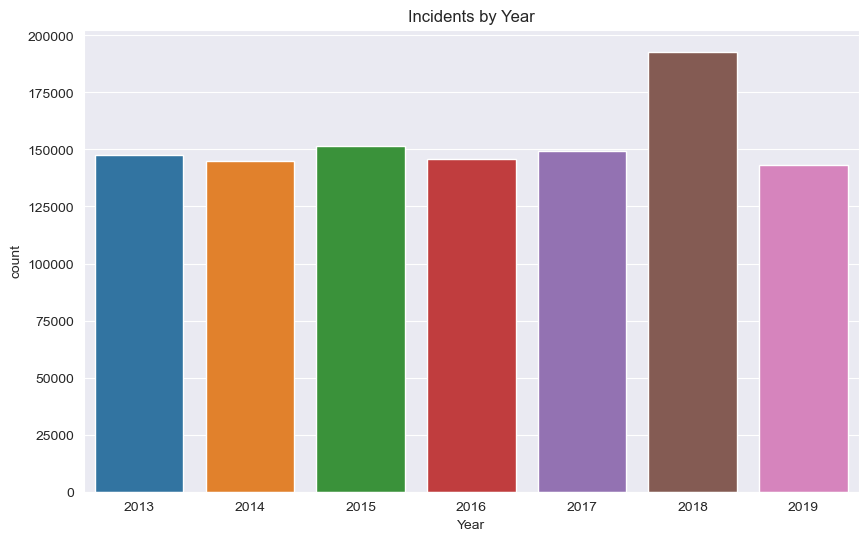

In [101]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
sns.countplot(x='Year', data=police_filtered)
plt.title('Incidents by Year')
plt.show()

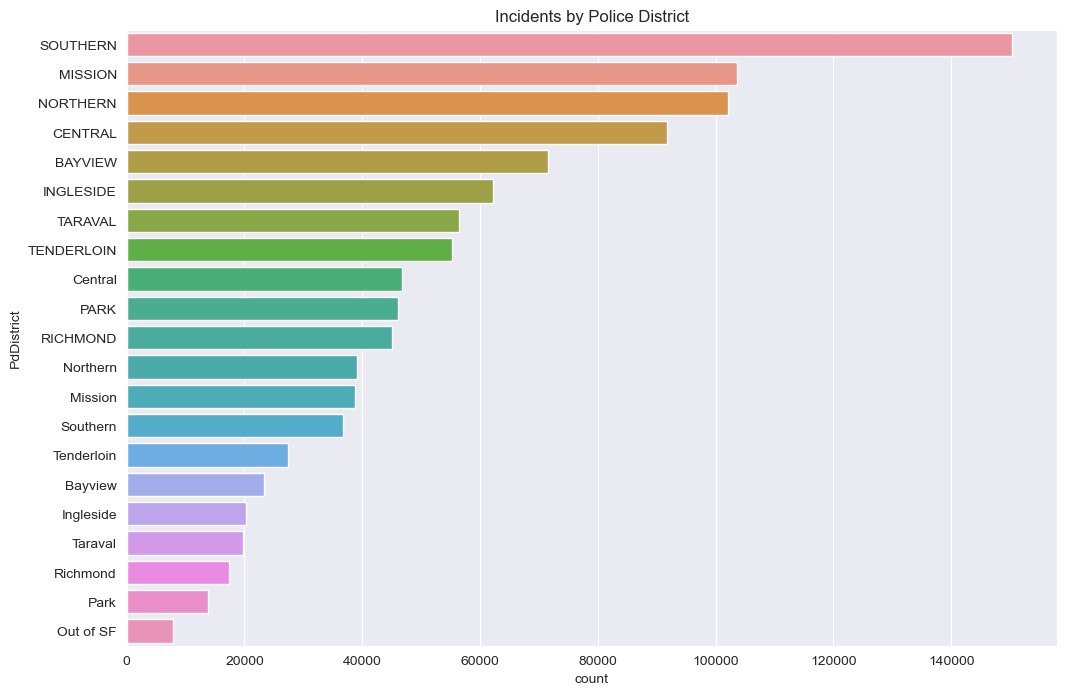

In [102]:
plt.figure(figsize=(12, 8))
sns.countplot(y='PdDistrict', data=police_filtered, order=police_filtered['PdDistrict'].value_counts().index)
plt.title('Incidents by Police District')
plt.show()

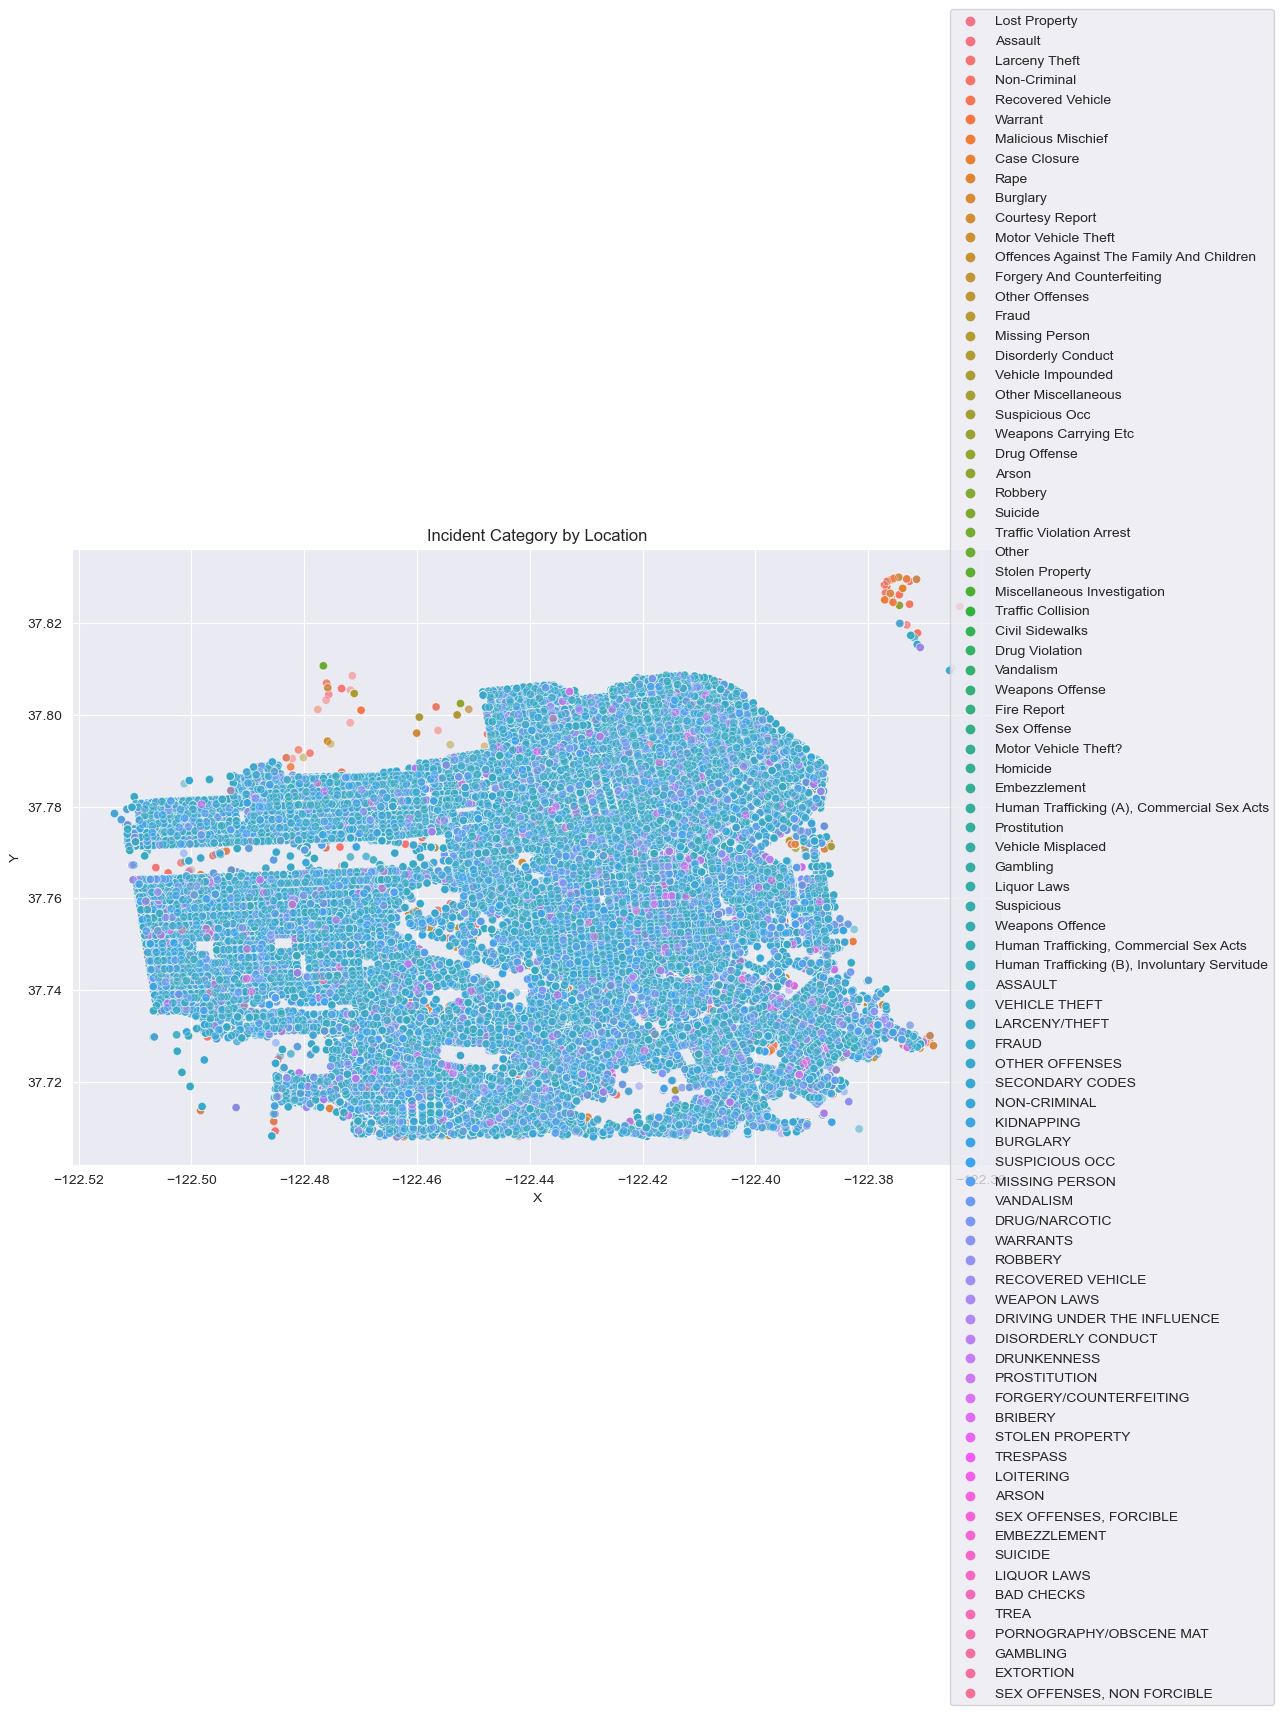

In [103]:
plt.figure(figsize=(12, 8))
scatterplot = sns.scatterplot(x='X', y='Y', hue='Category', data=police_filtered, alpha=0.5, legend='brief')
scatterplot.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
plt.title('Incident Category by Location')
plt.show()

In [150]:
#drop all missing coordinate values
police_filtered = police_filtered.dropna(subset=['X','Y'], how='all')
police_filtered.head()

,PdId,IncidntNum,Category,Date,PdDistrict,Address,X,Y,geometry,Incident Date,Year
309,1037700,210348157,Rape,2019/06/11 04:30:00 PM,Southern,0,-122.408846,37.775953,POINT (-122.40884575063417 37.775953228502786),2019-06-11 16:30:00,2019
1226,1135366,220204947,Courtesy Report,2019/06/01 12:00:00 AM,Out of SF,0,-122.391434,37.773467,POINT (-122.39143433652146 37.773466920607476),2019-06-01 00:00:00,2019
3071,1258117,236054370,Lost Property,2019/04/01 12:00:00 AM,Ingleside,0,-122.415291,37.713504,POINT (-122.41529083617453 37.71350427378473),2019-04-01 00:00:00,2019
3191,1258144,230206632,Fraud,2019/12/01 12:00:00 AM,Southern,0,-122.390527,37.780607,POINT (-122.39052723477022 37.78060675630406),2019-12-01 00:00:00,2019
4125,1259824,236024323,Larceny Theft,2019/02/06 06:00:00 PM,Tenderloin,0,-122.416401,37.777723,POINT (-122.41640107183976 37.777722750028566),2019-02-06 18:00:00,2019


In [157]:
#convert latitude and longitude to zipcode
data_poly = gpd.read_file("San Francisco ZIP Codes.geojson")

In [158]:
gdf = gpd.GeoDataFrame(police_filtered, geometry=gpd.points_from_xy(police_filtered.X, police_filtered.Y))
joined_gdf = gpd.sjoin(gdf, data_poly, op='within')

/opt/anaconda3/envs/w207_final/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/61/t0ms0p4146d2xnzbfxrp9rl40000gn/T/ipykernel_21141/955534676.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined_gdf = gpd.sjoin(gdf, data_poly, op='within')


In [160]:
#"id" column is zipcode
#print(joined_gdf.head())
joined_gdf['id'].value_counts()

94103    162104
94102    111369
94110     99057
94109     80986
94124     58493
94107     51237
94112     46098
94133     45430
94115     41872
94117     41092
94114     36408
94122     31495
94108     29770
94118     28595
94134     27009
94123     25576
94105     23778
94121     21358
94132     21341
94111     20677
94116     17880
94131     14970
94127      8716
94104      5856
94158      5494
94130      2242
94129       316
Name: id, dtype: int64

In [164]:
police_final = joined_gdf[['PdId', 'IncidntNum', 'Category', 'Date', 'Year', 'id']].rename(columns = {'id': 'zipcode'})
police_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1059219 entries, 309 to 2129372
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   PdId        1059219 non-null  int64 
 1   IncidntNum  1059219 non-null  int64 
 2   Category    1059207 non-null  object
 3   Date        1059219 non-null  object
 4   Year        1059219 non-null  int64 
 5   zipcode     1059219 non-null  object
dtypes: int64(3), object(3)
memory usage: 56.6+ MB


3. City Survey [EDA & Preprocessing]

In [167]:
#columns of interest
columns = [ "year", "dem_zip", "dem_district", "inf_clean", "inf_stcond", "inf_sidecond", "inf_clean_side", "inf_clean_st", "safe_day", "safe_night", "dem_hhsize"]
dfagg = city_df[columns]

In [168]:
#columns for cleanliness & exclude missing values and columns with ratings of 6 or 7
relevant_columns = ["inf_clean", "inf_stcond", "inf_sidecond", "inf_clean_side", "inf_clean_st"]
rating_map = {
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
}
dfagg[relevant_columns] = dfagg[relevant_columns].replace(rating_map)

# convert the ratings to numeric values and replace non-integer values with NaN
dfagg[relevant_columns] = dfagg[relevant_columns].applymap(lambda x: pd.to_numeric(x, errors='coerce'))

# compute the mean for each row, excluding NaN values
dfagg['cleanliness'] = dfagg[relevant_columns].mean(axis=1, skipna=True)

# print the result
dfagg['cleanliness'].value_counts()

/var/folders/61/t0ms0p4146d2xnzbfxrp9rl40000gn/T/ipykernel_21141/736386355.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfagg[relevant_columns] = dfagg[relevant_columns].replace(rating_map)
/var/folders/61/t0ms0p4146d2xnzbfxrp9rl40000gn/T/ipykernel_21141/736386355.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfagg[relevant_columns] = dfagg[relevant_columns].applymap(lambda x: pd.to_numeric(x, errors='coerce'))
/var/folders/61/t0ms0p4146d2xnzbfxrp9rl40000gn/T/ipykernel_21141/736386355.py:16: 

4.000000    5615
3.000000    5083
3.666667    2594
3.333333    2474
2.000000    2163
2.666667    1885
2.333333    1389
5.000000    1299
3.500000    1233
4.333333    1051
1.000000     906
2.500000     871
4.666667     794
1.666667     647
3.750000     438
3.250000     387
1.333333     362
4.500000     356
2.750000     356
4.250000     256
1.500000     223
2.250000     209
4.750000     147
1.750000      91
1.250000      33
Name: cleanliness, dtype: int64

In [169]:
dfagg = dfagg.drop(relevant_columns, axis=1)
df2019_cleaned = dfagg.rename(columns={"dem_zip":"zipcode", "dem_district": "district","dem_hhsize":"household_size"})
df2019_cleaned

,year,zipcode,district,safe_day,safe_night,household_size,cleanliness
0,2019,94112.0,11.0,4.0,2.0,6.0,3.333333
1,2019,99999.0,4.0,4.0,2.0,1.0,4.000000
2,2019,99999.0,NaN,5.0,2.0,2.0,3.666667
3,2019,99999.0,4.0,4.0,3.0,6.0,3.000000
4,2019,94132.0,7.0,4.0,3.0,3.0,5.000000
...,...,...,...,...,...,...,...
40185,1996,94116.0,NaN,3.0,3.0,3.0,NaN
40186,1996,94134.0,NaN,4.0,3.0,3.0,NaN
40187,1996,94112.0,NaN,4.0,4.0,4.0,NaN
40188,1996,94118.0,NaN,1.0,1.0,5.0,NaN


In [170]:
#find entries without/invalid zipcodes & fill with 0
df2019_cleaned['zipcode'] = df2019_cleaned['zipcode'].fillna(0).astype(int)
df2019_cleaned['zipcode'] = df2019_cleaned['zipcode'].replace([88888, 99999], 0)

In [171]:
#filter for years 2013-2019
survey_filtered = df2019_cleaned.loc[df2019_cleaned['year'] <= 2019]
survey_filtered = survey_filtered.loc[df2019_cleaned['year'] >= 2013]
survey_filtered

,year,zipcode,district,safe_day,safe_night,household_size,cleanliness
0,2019,94112,11.0,4.0,2.0,6.0,3.333333
1,2019,0,4.0,4.0,2.0,1.0,4.000000
2,2019,0,NaN,5.0,2.0,2.0,3.666667
3,2019,0,4.0,4.0,3.0,6.0,3.000000
4,2019,94132,7.0,4.0,3.0,3.0,5.000000
...,...,...,...,...,...,...,...
10186,2013,94126,9.0,NaN,NaN,NaN,NaN
10187,2013,94126,9.0,4.0,4.0,5.0,2.250000
10188,2013,94126,10.0,3.0,2.0,NaN,3.000000
10189,2013,94126,10.0,4.0,3.0,NaN,3.250000


**Notes:** 
- No zipcodes available for 2015
- Only have data every other year starting 2005

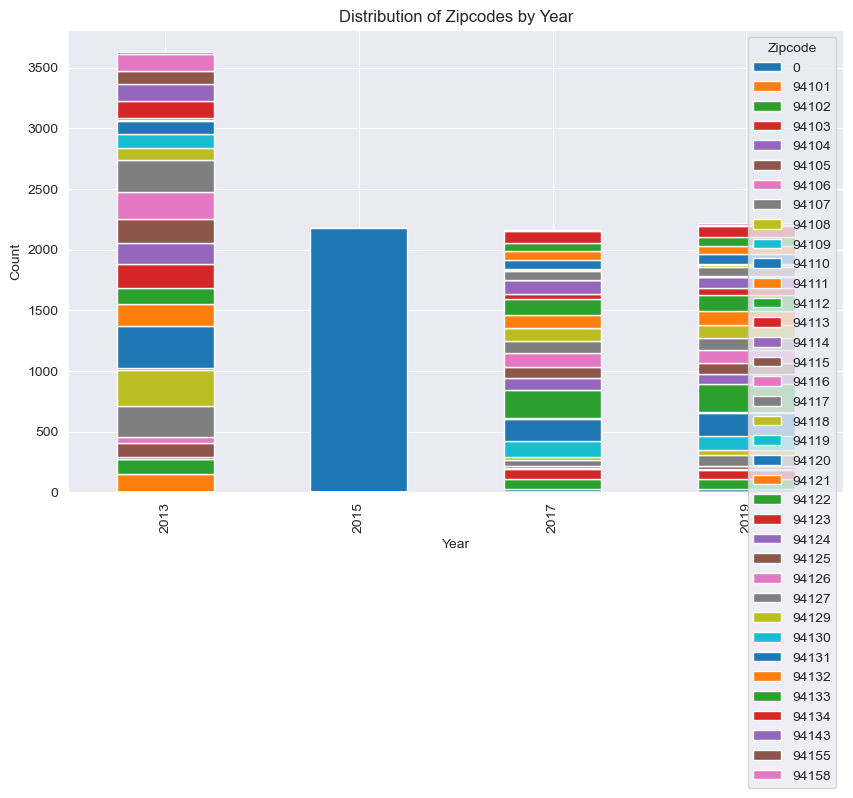

In [172]:
# group the data by year and zipcode and count the occurrences
grouped = survey_filtered.groupby(['year', 'zipcode']).size().unstack()

# plot a stacked bar chart
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))

# customize the plot
ax.set_xlabel('Year') 
ax.set_ylabel('Count')
ax.legend(title='Zipcode', loc='upper right')
ax.set_title('Distribution of Zipcodes by Year')
plt.show()

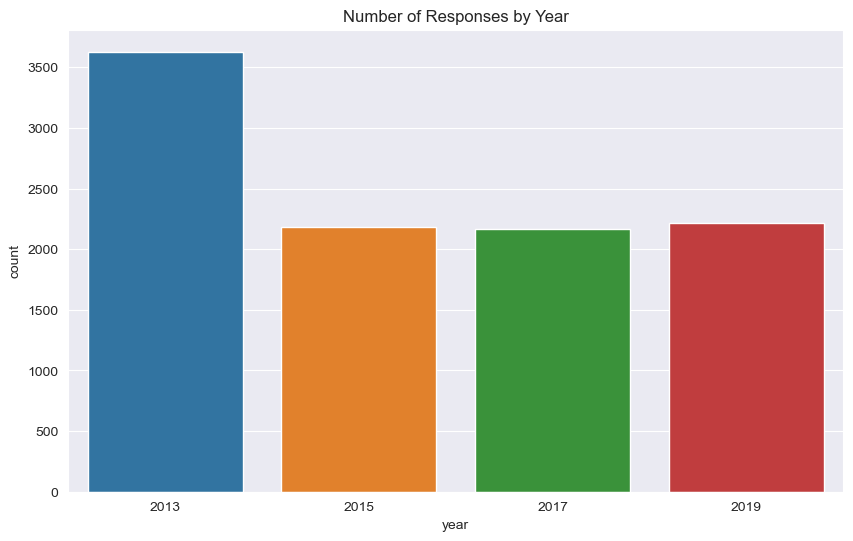

In [175]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
sns.countplot(x='year', data=survey_filtered)
plt.title('Number of Responses by Year')
plt.show()

In [196]:
#2015 has no zipcode data
survey_filtered[survey_filtered['year'] == 2015]

,year,zipcode,district,safe_day,safe_night,household_size,cleanliness
4384,2015,0,8.0,NaN,NaN,1.0,4.00
4385,2015,0,2.0,5.0,3.0,1.0,NaN
4386,2015,0,5.0,5.0,NaN,1.0,NaN
4387,2015,0,7.0,5.0,5.0,2.0,NaN
4388,2015,0,6.0,NaN,NaN,1.0,3.25
...,...,...,...,...,...,...,...
6558,2015,0,12.0,NaN,NaN,3.0,3.25
6559,2015,0,1.0,5.0,5.0,1.0,NaN
6560,2015,0,8.0,NaN,NaN,2.0,4.00
6561,2015,0,9.0,5.0,5.0,3.0,NaN


In [201]:
#unable to identify correct zipcode for zipcode value 0 (missing data) by district since there are multiiple zipcodes per district
survey_filtered.groupby(['district', 'zipcode']).count()

year  safe_day  safe_night  household_size  cleanliness
district zipcode                                                         
1.0      0         151        75          73             151           77
         94104       1         1           1               1            0
         94105       1         1           1               1            1
         94109       1         1           1               1            1
         94114       5         5           5               5            5
...                ...       ...         ...             ...          ...
11.0     94127       9         9           8               9            8
         94131       1         0           0               1            1
         94132      31        21          20              31           21
         94134      20        20          20              20           15
12.0     0          81        44          41              81           35

[216 rows x 5 columns]

In [223]:
#fill in gap years with previous year data (i.e. fill in 2014 & 2015 & 2016 data with 2013 data)

#drop 2015 data without zipcodes
survey_filtered1 = survey_filtered[survey_filtered.zipcode != 0]
survey_filtered1.year.value_counts()

#Want 2013-2019

#create 2014, 2015, 2016 data with 2013 data
df2014 = survey_filtered1[survey_filtered1.year == 2013]
df2014['year'] = df2014['year'].replace(2013, 2014)
df2015 = survey_filtered1[survey_filtered1.year == 2013]
df2015['year'] = df2015['year'].replace(2013, 2015)
df2016 = survey_filtered1[survey_filtered1.year == 2013]
df2016['year'] = df2016['year'].replace(2013, 2016)

#create 2018 data with 2017 data
df2018 = survey_filtered1[survey_filtered1.year == 2017]
df2018['year'] = df2018['year'].replace(2017, 2018)

#append all dataframes back to original df --> survey_filtered
survey_final = pd.concat([survey_filtered1, df2014, df2015, df2016, df2018])
survey_final

/var/folders/61/t0ms0p4146d2xnzbfxrp9rl40000gn/T/ipykernel_21141/2550943389.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2014['year'] = df2014['year'].replace(2013, 2014)
/var/folders/61/t0ms0p4146d2xnzbfxrp9rl40000gn/T/ipykernel_21141/2550943389.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2015['year'] = df2015['year'].replace(2013, 2015)
/var/folders/61/t0ms0p4146d2xnzbfxrp9rl40000gn/T/ipykernel_21141/2550943389.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,year,zipcode,district,safe_day,safe_night,household_size,cleanliness
0,2019,94112,11.0,4.0,2.0,6.0,3.333333
4,2019,94132,7.0,4.0,3.0,3.0,5.000000
5,2019,94134,10.0,4.0,1.0,0.0,1.666667
6,2019,94117,6.0,5.0,5.0,2.0,3.000000
7,2019,94122,3.0,4.0,4.0,3.0,3.000000
...,...,...,...,...,...,...,...
4379,2018,94115,5.0,NaN,NaN,2.0,4.333333
4380,2018,94115,2.0,NaN,NaN,2.0,NaN
4381,2018,94134,10.0,NaN,NaN,4.0,NaN
4382,2018,94110,9.0,5.0,4.0,3.0,NaN


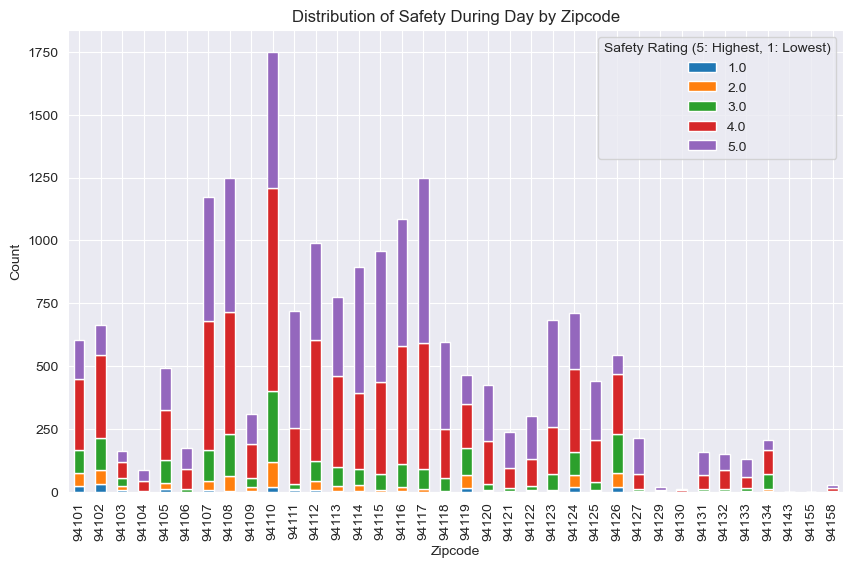

In [225]:
# group the data by year and zipcode and count the occurrences
grouped = survey_final.groupby(['zipcode', 'safe_day']).size().unstack()

# plot a stacked bar chart
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))

# customize the plot
ax.set_xlabel('Zipcode') 
ax.set_ylabel('Count')
ax.legend(title='Safety Rating (5: Highest, 1: Lowest)', loc='upper right')
ax.set_title('Distribution of Safety During Day by Zipcode')
plt.show()

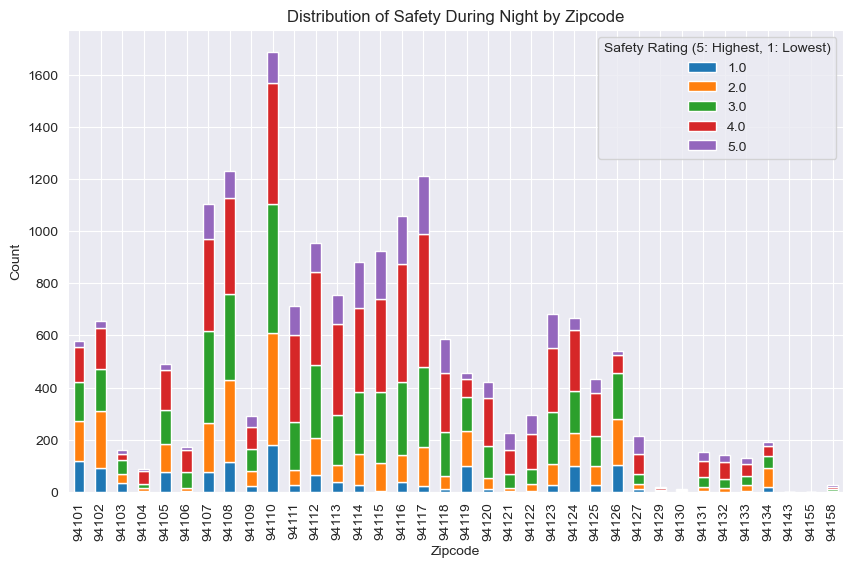

In [227]:
# group the data by year and zipcode and count the occurrences
grouped = survey_final.groupby(['zipcode', 'safe_night']).size().unstack()

# plot a stacked bar chart
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))

# customize the plot
ax.set_xlabel('Zipcode') 
ax.set_ylabel('Count')
ax.legend(title='Safety Rating (5: Highest, 1: Lowest)', loc='upper right')
ax.set_title('Distribution of Safety During Night by Zipcode')
plt.show()

4. Final Police Crime & City Surey Data **[Join these with House Valuation Dataset]**

In [226]:
#Final dataframes for Years 2013-2019
display(survey_final)
display(police_final)

,year,zipcode,district,safe_day,safe_night,household_size,cleanliness
0,2019,94112,11.0,4.0,2.0,6.0,3.333333
4,2019,94132,7.0,4.0,3.0,3.0,5.000000
5,2019,94134,10.0,4.0,1.0,0.0,1.666667
6,2019,94117,6.0,5.0,5.0,2.0,3.000000
7,2019,94122,3.0,4.0,4.0,3.0,3.000000
...,...,...,...,...,...,...,...
4379,2018,94115,5.0,NaN,NaN,2.0,4.333333
4380,2018,94115,2.0,NaN,NaN,2.0,NaN
4381,2018,94134,10.0,NaN,NaN,4.0,NaN
4382,2018,94110,9.0,5.0,4.0,3.0,NaN


,PdId,IncidntNum,Category,Date,Year,zipcode
309,1037700,210348157,Rape,2019/06/11 04:30:00 PM,2019,94103
9854,670158,180373979,Assault,2018/05/18 03:57:00 PM,2018,94103
9942,654748,180260514,Arson,2018/04/08 11:25:00 PM,2018,94103
10648,818145,190478644,Warrant,2019/07/02 01:35:00 PM,2019,94103
11494,870625,190866124,Assault,2019/11/15 04:40:00 PM,2019,94103
...,...,...,...,...,...,...
2128576,17026429772000,170264297,NON-CRIMINAL,03/31/2017,2017,94104
2128672,17620189306314,176201893,LARCENY/THEFT,08/02/2017,2017,94104
2128752,17038714064020,170387140,NON-CRIMINAL,05/11/2017,2017,94104
2128987,17060849109320,170608491,FRAUD,07/25/2017,2017,94104


5. Load in House Valuation Dataset to Join with Police Crime & City Survey Data

In [244]:
#load in cleaned house valuation data
val_final = pd.read_csv("val_clean.csv").rename(columns = {'Closed Roll Year': 'Year'})
val_final.head()

,Year,Zipcode,Assessed Improvement Value,Assessed Land Value,Assessed Personal Property Value,Year Property Built,Number of Bathrooms,Number of Bedrooms,Number of Rooms,Number of Stories,Number of Units,Assessor Neighborhood District,Assessor Neighborhood Code,Total Assessed Value
0,2016,94121,181379,181379,0,1980.0,1.0,1,3.0,1.0,1,1.0,1E,362758
1,2016,94121,401392,577844,0,1914.0,6.0,9,21.0,3.0,6,1.0,1D,979236
2,2016,94121,259562,389342,0,1925.0,2.0,4,8.0,1.0,1,1.0,1E,648904
3,2016,94121,294460,441694,0,1911.0,1.0,3,6.0,2.0,1,1.0,1E,736154
4,2016,94121,488640,1140160,0,1900.0,2.0,0,6.0,2.0,1,1.0,1A,1628800


In [276]:
#get the count of incidents from police_final 
police_final2 = police_final.groupby(['Year','zipcode']).count().reset_index().rename(columns = {'PdId':'Incident Counts', 'zipcode':'Zipcode'})
police_final2 = police_final2.drop(columns = ['IncidntNum','Date', 'Category'])
police_final2

,Year,Zipcode,Incident Counts
0,2013,94102,17610
1,2013,94103,24390
2,2013,94104,675
3,2013,94105,2881
4,2013,94107,6867
...,...,...,...
180,2019,94131,2209
181,2019,94132,2900
182,2019,94133,6434
183,2019,94134,3545


In [248]:
#get average of safe_day,safe_night,household_size,cleanliness for each year,zipcode pair
survey_final2 = survey_final.groupby(['year','zipcode']).mean().reset_index().drop(columns = ['district']).rename(columns = {'year': 'Year', 'zipcode':'Zipcode'})
survey_final2

,Year,Zipcode,safe_day,safe_night,household_size,cleanliness
0,2013,94101,3.814570,2.641379,1.753425,3.127222
1,2013,94102,3.696721,2.680328,2.121951,2.958333
2,2013,94103,5.000000,3.000000,1.000000,3.500000
3,2013,94104,4.611111,3.611111,1.611111,3.375000
4,2013,94105,3.963636,2.818182,1.981818,3.295045
...,...,...,...,...,...,...
196,2019,94133,4.202703,3.297297,2.554054,2.972973
197,2019,94134,3.865169,2.865854,3.351648,3.157509
198,2019,94143,3.000000,1.000000,5.000000,1.333333
199,2019,94155,3.000000,3.000000,3.000000,3.000000


In [248]:
#get average of safe_day,safe_night,household_size,cleanliness for each year,zipcode pair
survey_final2 = survey_final.groupby(['year','zipcode']).mean().reset_index().drop(columns = ['district']).rename(columns = {'year': 'Year', 'zipcode':'Zipcode'})
survey_final2

,Year,Zipcode,safe_day,safe_night,household_size,cleanliness
0,2013,94101,3.814570,2.641379,1.753425,3.127222
1,2013,94102,3.696721,2.680328,2.121951,2.958333
2,2013,94103,5.000000,3.000000,1.000000,3.500000
3,2013,94104,4.611111,3.611111,1.611111,3.375000
4,2013,94105,3.963636,2.818182,1.981818,3.295045
...,...,...,...,...,...,...
196,2019,94133,4.202703,3.297297,2.554054,2.972973
197,2019,94134,3.865169,2.865854,3.351648,3.157509
198,2019,94143,3.000000,1.000000,5.000000,1.333333
199,2019,94155,3.000000,3.000000,3.000000,3.000000


In [277]:
#check datatypes
#val_final.info(), police_final2.info(), survey_final2.info()

#convert police_final2 Zipcode column from str-->int
police_final2['Zipcode'] = police_final2.Zipcode.astype(int)
police_final2

val_final.info(), police_final2.info(), survey_final2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1418630 entries, 0 to 1418629
Data columns (total 14 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   Year                              1418630 non-null  int64  
 1   Zipcode                           1418630 non-null  int64  
 2   Assessed Improvement Value        1418630 non-null  int64  
 3   Assessed Land Value               1418630 non-null  int64  
 4   Assessed Personal Property Value  1418630 non-null  int64  
 5   Year Property Built               1340181 non-null  float64
 6   Number of Bathrooms               1418630 non-null  float64
 7   Number of Bedrooms                1418630 non-null  int64  
 8   Number of Rooms                   1418625 non-null  float64
 9   Number of Stories                 1418623 non-null  float64
 10  Number of Units                   1418630 non-null  int64  
 11  Assessor Neighborhood District    141

(None, None, None)

In [279]:
#left join on val_final with police_final2
join1 = pd.merge(val_final, police_final2, on = ['Year', 'Zipcode'], how = 'left')
join1

,Year,Zipcode,Assessed Improvement Value,Assessed Land Value,Assessed Personal Property Value,Year Property Built,Number of Bathrooms,Number of Bedrooms,Number of Rooms,Number of Stories,Number of Units,Assessor Neighborhood District,Assessor Neighborhood Code,Total Assessed Value,Incident Counts
0,2016,94121,181379,181379,0,1980.0,1.0,1,3.0,1.0,1,1.0,1E,362758,3109
1,2016,94121,401392,577844,0,1914.0,6.0,9,21.0,3.0,6,1.0,1D,979236,3109
2,2016,94121,259562,389342,0,1925.0,2.0,4,8.0,1.0,1,1.0,1E,648904,3109
3,2016,94121,294460,441694,0,1911.0,1.0,3,6.0,2.0,1,1.0,1E,736154,3109
4,2016,94121,488640,1140160,0,1900.0,2.0,0,6.0,2.0,1,1.0,1A,1628800,3109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418625,2019,94134,220700,220700,0,1994.0,2.0,2,5.0,1.0,1,10.0,10B,441400,3545
1418626,2019,94134,258092,258092,0,1990.0,2.0,2,4.0,1.0,1,10.0,10B,516184,3545
1418627,2019,94134,134700,94328,0,1987.0,2.0,3,6.0,0.0,1,10.0,10B,229028,3545
1418628,2019,94134,198114,198114,0,1987.0,2.0,3,6.0,0.0,1,10.0,10B,396228,3545


In [304]:
join1 = join1.dropna(subset = ['Year Property Built'])
join1

,Year,Zipcode,Assessed Improvement Value,Assessed Land Value,Assessed Personal Property Value,Year Property Built,Number of Bathrooms,Number of Bedrooms,Number of Rooms,Number of Stories,Number of Units,Total Assessed Value,Incident Counts
0,2016,94121,181379,181379,0,1980.0,1.0,1,3.0,1.0,1,362758,3109
1,2016,94121,401392,577844,0,1914.0,6.0,9,21.0,3.0,6,979236,3109
2,2016,94121,259562,389342,0,1925.0,2.0,4,8.0,1.0,1,648904,3109
3,2016,94121,294460,441694,0,1911.0,1.0,3,6.0,2.0,1,736154,3109
4,2016,94121,488640,1140160,0,1900.0,2.0,0,6.0,2.0,1,1628800,3109
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418624,2019,94134,225124,225124,0,1994.0,2.0,2,5.0,1.0,1,450248,3545
1418625,2019,94134,220700,220700,0,1994.0,2.0,2,5.0,1.0,1,441400,3545
1418626,2019,94134,258092,258092,0,1990.0,2.0,2,4.0,1.0,1,516184,3545
1418627,2019,94134,134700,94328,0,1987.0,2.0,3,6.0,0.0,1,229028,3545


In [305]:
#left join join1 with survey_final2
final_df = pd.merge(join1, survey_final2, on = ['Year', 'Zipcode'], how = 'inner')

#final dataframe
final_df

,Year,Zipcode,Assessed Improvement Value,Assessed Land Value,Assessed Personal Property Value,Year Property Built,Number of Bathrooms,Number of Bedrooms,Number of Rooms,Number of Stories,Number of Units,Total Assessed Value,Incident Counts,safe_day,safe_night,household_size,cleanliness
0,2016,94121,181379,181379,0,1980.0,1.0,1,3.0,1.0,1,362758,3109,4.571429,4.333333,3.428571,3.750000
1,2016,94121,401392,577844,0,1914.0,6.0,9,21.0,3.0,6,979236,3109,4.571429,4.333333,3.428571,3.750000
2,2016,94121,259562,389342,0,1925.0,2.0,4,8.0,1.0,1,648904,3109,4.571429,4.333333,3.428571,3.750000
3,2016,94121,294460,441694,0,1911.0,1.0,3,6.0,2.0,1,736154,3109,4.571429,4.333333,3.428571,3.750000
4,2016,94121,488640,1140160,0,1900.0,2.0,0,6.0,2.0,1,1628800,3109,4.571429,4.333333,3.428571,3.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224077,2019,94134,225124,225124,0,1994.0,2.0,2,5.0,1.0,1,450248,3545,3.865169,2.865854,3.351648,3.157509
1224078,2019,94134,220700,220700,0,1994.0,2.0,2,5.0,1.0,1,441400,3545,3.865169,2.865854,3.351648,3.157509
1224079,2019,94134,258092,258092,0,1990.0,2.0,2,4.0,1.0,1,516184,3545,3.865169,2.865854,3.351648,3.157509
1224080,2019,94134,134700,94328,0,1987.0,2.0,3,6.0,0.0,1,229028,3545,3.865169,2.865854,3.351648,3.157509


In [306]:
#correlation of Total Assessed Value with other features
final_df.corr().loc['Total Assessed Value']

#drop Assessed Improvement Value & Assessed Land Value since both were used to calculate to Total Assessed Value
final_df = final_df.drop(columns = ['Assessed Improvement Value', 'Assessed Land Value'])
final_df

,Year,Zipcode,Assessed Personal Property Value,Year Property Built,Number of Bathrooms,Number of Bedrooms,Number of Rooms,Number of Stories,Number of Units,Total Assessed Value,Incident Counts,safe_day,safe_night,household_size,cleanliness
0,2016,94121,0,1980.0,1.0,1,3.0,1.0,1,362758,3109,4.571429,4.333333,3.428571,3.750000
1,2016,94121,0,1914.0,6.0,9,21.0,3.0,6,979236,3109,4.571429,4.333333,3.428571,3.750000
2,2016,94121,0,1925.0,2.0,4,8.0,1.0,1,648904,3109,4.571429,4.333333,3.428571,3.750000
3,2016,94121,0,1911.0,1.0,3,6.0,2.0,1,736154,3109,4.571429,4.333333,3.428571,3.750000
4,2016,94121,0,1900.0,2.0,0,6.0,2.0,1,1628800,3109,4.571429,4.333333,3.428571,3.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224077,2019,94134,0,1994.0,2.0,2,5.0,1.0,1,450248,3545,3.865169,2.865854,3.351648,3.157509
1224078,2019,94134,0,1994.0,2.0,2,5.0,1.0,1,441400,3545,3.865169,2.865854,3.351648,3.157509
1224079,2019,94134,0,1990.0,2.0,2,4.0,1.0,1,516184,3545,3.865169,2.865854,3.351648,3.157509
1224080,2019,94134,0,1987.0,2.0,3,6.0,0.0,1,229028,3545,3.865169,2.865854,3.351648,3.157509


In [418]:
#one hot encode zipcode
df_encoded = pd.get_dummies(final_df, columns = ['Zipcode'], drop_first = True) #avoid multicollinearity
df_encoded.columns

Index(['Year', 'Assessed Personal Property Value', 'Year Property Built',
       'Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms',
       'Number of Stories', 'Number of Units', 'Total Assessed Value',
       'Incident Counts', 'safe_day', 'safe_night', 'household_size',
       'cleanliness', 'Zipcode_94103', 'Zipcode_94104', 'Zipcode_94105',
       'Zipcode_94107', 'Zipcode_94108', 'Zipcode_94109', 'Zipcode_94110',
       'Zipcode_94111', 'Zipcode_94112', 'Zipcode_94114', 'Zipcode_94115',
       'Zipcode_94116', 'Zipcode_94117', 'Zipcode_94118', 'Zipcode_94121',
       'Zipcode_94122', 'Zipcode_94123', 'Zipcode_94124', 'Zipcode_94127',
       'Zipcode_94131', 'Zipcode_94132', 'Zipcode_94133', 'Zipcode_94134',
       'Zipcode_94158'],
      dtype='object')

6. Model Implementation
- Note: model might underestimate since increase in tax rate does not keep up with real-world inflation in California

In [419]:
#check nans
df_encoded.isna().sum()

df_encoded = df_encoded.dropna()
df_encoded.columns


#log of Total Assessed Value
df_encoded['Log of Total Assessed Value'] = np.log(df_encoded['Total Assessed Value'])

In [420]:
#train_test split
X = df_encoded[['Year', 'Assessed Personal Property Value', 'Year Property Built',
       'Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms',
       'Number of Stories', 'Number of Units', 
       'Incident Counts', 'safe_day', 'safe_night', 'household_size',
       'cleanliness', 'Zipcode_94103', 'Zipcode_94104', 'Zipcode_94105',
       'Zipcode_94107', 'Zipcode_94108', 'Zipcode_94109', 'Zipcode_94110',
       'Zipcode_94111', 'Zipcode_94112', 'Zipcode_94114', 'Zipcode_94115',
       'Zipcode_94116', 'Zipcode_94117', 'Zipcode_94118', 'Zipcode_94121',
       'Zipcode_94122', 'Zipcode_94123', 'Zipcode_94124', 'Zipcode_94127',
       'Zipcode_94131', 'Zipcode_94132', 'Zipcode_94133', 'Zipcode_94134',
       'Zipcode_94158']]
Y = df_encoded['Log of Total Assessed Value']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 42)

- **Model 1: Linear Regression**

In [460]:
#model
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [461]:
feature = ['Year', 'Assessed Personal Property Value', 'Year Property Built',
       'Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms',
       'Number of Stories', 'Number of Units', 
       'Incident Counts', 'safe_day', 'safe_night', 'household_size',
       'cleanliness', 'Zipcode_94103', 'Zipcode_94104', 'Zipcode_94105',
       'Zipcode_94107', 'Zipcode_94108', 'Zipcode_94109', 'Zipcode_94110',
       'Zipcode_94111', 'Zipcode_94112', 'Zipcode_94114', 'Zipcode_94115',
       'Zipcode_94116', 'Zipcode_94117', 'Zipcode_94118', 'Zipcode_94121',
       'Zipcode_94122', 'Zipcode_94123', 'Zipcode_94124', 'Zipcode_94127',
       'Zipcode_94131', 'Zipcode_94132', 'Zipcode_94133', 'Zipcode_94134',
       'Zipcode_94158']

#construct dataframe of each feature & the corresponding coefficients
pd.DataFrame(zip(feature, model.coef_), columns = ['feature', 'coefficients'])

#Note: Zipcode_94104 & few others have many commercial buildings / tech companies

,feature,coefficients
0,Year,5.531197e-02
1,Assessed Personal Property Value,8.825725e-08
2,Year Property Built,1.940551e-03
3,Number of Bathrooms,1.721936e-02
4,Number of Bedrooms,4.001798e-03
5,Number of Rooms,3.498326e-03
6,Number of Stories,3.683206e-03
7,Number of Units,1.272868e-03
8,Incident Counts,3.074713e-07
9,safe_day,-7.346348e-10


In [463]:
Y_pred_test = model.predict(X_test)
Y_pred_train = model.predict(X_train)
mean_squared_error(np.exp(Y_test), np.exp(Y_pred_test))**(1/2), mean_squared_error(np.exp(Y_train), np.exp(Y_pred_train))**(1/2)

(453990814667.7881, 573812345255.2048)

**Hyperparameter Tuning for Linear Regression**

1. Select Features

In [388]:
#narrow down features to the ones most correlated with Log of Total Assessed Value
df_encoded.corr().loc['Total Assessed Value'].sort_values(ascending=False)

Total Assessed Value                1.000000
Log of Total Assessed Value         0.270051
Number of Rooms                     0.194782
Number of Bathrooms                 0.192179
Number of Units                     0.177627
Assessed Personal Property Value    0.130158
Zipcode_94104                       0.105602
Number of Stories                   0.069985
Zipcode_94105                       0.058748
Zipcode_94111                       0.055951
Zipcode_94108                       0.032365
Year Property Built                 0.025930
Zipcode_94103                       0.020725
Year                                0.018823
Number of Bedrooms                  0.018023
Zipcode_94158                       0.016548
Zipcode_94123                       0.011236
Zipcode_94115                       0.008209
Incident Counts                     0.007272
Zipcode_94133                       0.006481
Zipcode_94109                       0.006051
Zipcode_94107                       0.001006
Zipcode_94

In [389]:
#take all features with >0.05 or <-0.05 coefficient & redo train-test split

#train_test split
X = df_encoded[['Number of Bathrooms', 'Number of Rooms', 'Zipcode_94123','Number of Units','Zipcode_94105','Zipcode_94124','household_size'                    
,'Zipcode_94112','Zipcode_94134','Zipcode_94122','Zipcode_94116','cleanliness','Year','Year Property Built','Zipcode_94104'                       
,'Zipcode_94115','Number of Bedrooms','Zipcode_94109','Zipcode_94111','Number of Stories','Zipcode_94114','Zipcode_94103'                     
,'Zipcode_94108','safe_day']]
Y = df_encoded['Log of Total Assessed Value']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 42)

In [390]:
#model
model2 = LinearRegression()
model2.fit(X_train, Y_train)

LinearRegression()

In [391]:
feature2 = ['Number of Bathrooms', 'Number of Rooms', 'Zipcode_94123','Number of Units','Zipcode_94105','Zipcode_94124','household_size'                    
,'Zipcode_94112','Zipcode_94134','Zipcode_94122','Zipcode_94116','cleanliness','Year','Year Property Built','Zipcode_94104'                       
,'Zipcode_94115','Number of Bedrooms','Zipcode_94109','Zipcode_94111','Number of Stories','Zipcode_94114','Zipcode_94103'                     
,'Zipcode_94108','safe_day']

#construct dataframe of each feature & the corresponding coefficients
pd.DataFrame(zip(feature, model2.coef_), columns = ['feature', 'coefficients'])

,feature,coefficients
0,Year,0.016507
1,Assessed Personal Property Value,0.003770
2,Year Property Built,0.501553
3,Number of Bathrooms,0.001545
4,Number of Bedrooms,0.476264
5,Number of Rooms,-0.551444
6,Number of Stories,-0.089235
7,Number of Units,-0.506810
8,Incident Counts,-0.516346
9,safe_day,-0.247252


In [392]:
#predict on train set
Y_pred_train = model2.predict(X_train)

#RMSE
mean_squared_error(Y_train, Y_pred_train)**(1/2)

1.0084271159982559

In [393]:
#predict on test set
Y_pred_test = model2.predict(X_test)

#RMSE
mean_squared_error(Y_test, Y_pred_test)**(1/2)

1.0081373198290817

- **Model 2: Random Forest Regression**

In [394]:
#train_test split
X = df_encoded[['Year', 'Assessed Personal Property Value', 'Year Property Built',
       'Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms',
       'Number of Stories', 'Number of Units', 
       'Incident Counts', 'safe_day', 'safe_night', 'household_size',
       'cleanliness', 'Zipcode_94103', 'Zipcode_94104', 'Zipcode_94105',
       'Zipcode_94107', 'Zipcode_94108', 'Zipcode_94109', 'Zipcode_94110',
       'Zipcode_94111', 'Zipcode_94112', 'Zipcode_94114', 'Zipcode_94115',
       'Zipcode_94116', 'Zipcode_94117', 'Zipcode_94118', 'Zipcode_94121',
       'Zipcode_94122', 'Zipcode_94123', 'Zipcode_94124', 'Zipcode_94127',
       'Zipcode_94131', 'Zipcode_94132', 'Zipcode_94133', 'Zipcode_94134',
       'Zipcode_94158']]
Y = df_encoded['Log of Total Assessed Value']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 42)

In [395]:
rf = RandomForestRegressor(n_estimators=10, random_state=42)  
rf.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [396]:
#make predictions on test
Y_pred2 = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred2)
rmse = mse ** (1/2)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

Mean Squared Error: 0.63
Root Mean Squared Error: 0.80


**Log features & response**

In [424]:
#safe_day, safe_night, cleanliness --> convert these to binary (<3 not safe/clean, >= 3 safe/clean)
df_encoded['safe_day_binary'] = np.where(df_encoded['safe_day']<3, 0, 1)
df_encoded['safe_night_binary'] = np.where(df_encoded['safe_night']<3, 0, 1)
df_encoded['cleanliness_binary'] = np.where(df_encoded['cleanliness']<3, 0, 1)

In [425]:
X = df_encoded[['Year', 'Assessed Personal Property Value', 'Year Property Built',
       'Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms',
       'Number of Stories', 'Number of Units', 
       'Incident Counts', 'safe_day_binary', 'safe_night_binary', 'household_size',
       'cleanliness_binary', 'Zipcode_94103', 'Zipcode_94104', 'Zipcode_94105',
       'Zipcode_94107', 'Zipcode_94108', 'Zipcode_94109', 'Zipcode_94110',
       'Zipcode_94111', 'Zipcode_94112', 'Zipcode_94114', 'Zipcode_94115',
       'Zipcode_94116', 'Zipcode_94117', 'Zipcode_94118', 'Zipcode_94121',
       'Zipcode_94122', 'Zipcode_94123', 'Zipcode_94124', 'Zipcode_94127',
       'Zipcode_94131', 'Zipcode_94132', 'Zipcode_94133', 'Zipcode_94134',
       'Zipcode_94158']]
Y = df_encoded['Log of Total Assessed Value']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 42)

In [426]:
rf = RandomForestRegressor(n_estimators=10, random_state=42)  
rf.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [428]:
#make predictions on test
Y_pred2 = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred2)
rmse = mse ** (1/2)

rmse_unlogged = mean_squared_error(np.exp(Y_test), np.exp(Y_pred2)) ** (1/2)


print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Root Mean Squared Error (un-logged): {rmse_unlogged:.2f}")

Mean Squared Error: 0.62
Root Mean Squared Error: 0.79
Root Mean Squared Error (un-logged): 4406589.62


In [429]:
rmse_unlogged = mean_squared_error(np.exp(Y_test), np.exp(Y_pred2)) ** (1/2)
Y_pred2_train = rf.predict(X_train)
rmse_unlogged_train = mean_squared_error(np.exp(Y_train), np.exp(Y_pred2_train)) ** (1/2)
rmse_unlogged, rmse_unlogged_train

(4406589.618387294, 3017891.8552889577)

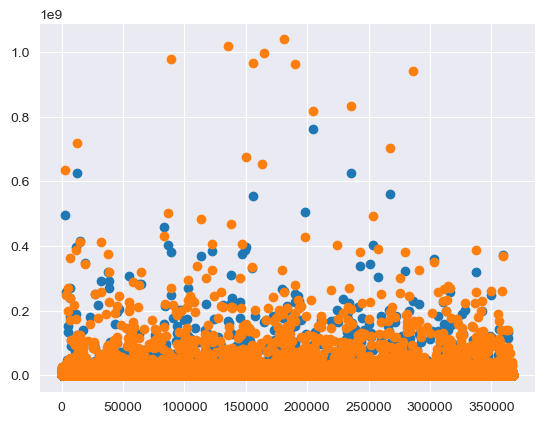

In [438]:
plt.scatter(np.arange(len(X_test)),np.exp(Y_pred2))
plt.scatter(np.arange(len(X_test)),np.exp(Y_test))

In [439]:
#increase n_estimators to 20
rf2 = RandomForestRegressor(n_estimators=20, random_state=42)  
rf2.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

In [440]:
#make predictions on test
Y_pred2 = rf2.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred2)
rmse = mse ** (1/2)

rmse_unlogged = mean_squared_error(np.exp(Y_test), np.exp(Y_pred2)) ** (1/2)


print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Root Mean Squared Error (un-logged): {rmse_unlogged:.2f}")

Mean Squared Error: 0.61
Root Mean Squared Error: 0.78
Root Mean Squared Error (un-logged): 4205377.81


In [441]:
rmse_unlogged = mean_squared_error(np.exp(Y_test), np.exp(Y_pred2)) ** (1/2)
Y_pred2_train = rf2.predict(X_train)
rmse_unlogged_train = mean_squared_error(np.exp(Y_train), np.exp(Y_pred2_train)) ** (1/2)
rmse_unlogged, rmse_unlogged_train

(4205377.808776414, 3017891.8552889577)

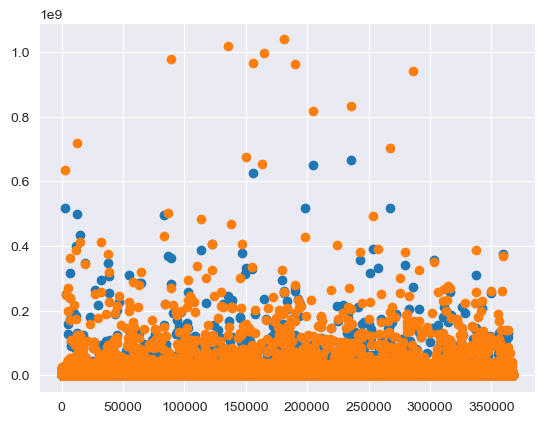

In [442]:
plt.scatter(np.arange(len(X_test)),np.exp(Y_pred2))
plt.scatter(np.arange(len(X_test)),np.exp(Y_test))

**Remove data points with valuation above 500 million to avoid outliers**

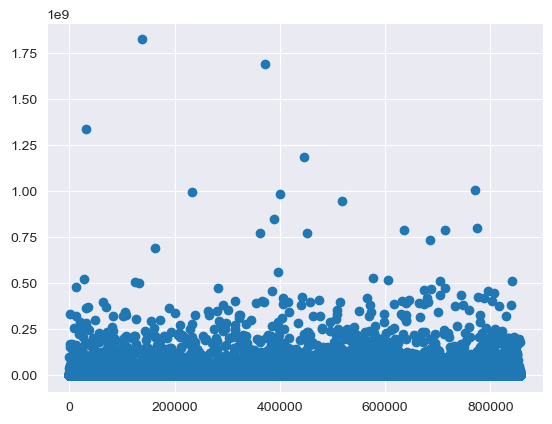

In [443]:
plt.scatter(np.arange(len(X_train)),np.exp(Y_train))

In [455]:
#filter for 'Total Assessed Value' < 250000000
df_new = df_encoded[df_encoded['Total Assessed Value'] < 250000000]

#train-test-split
X = df_new[['Year', 'Assessed Personal Property Value', 'Year Property Built',
       'Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms',
       'Number of Stories', 'Number of Units', 
       'Incident Counts', 'safe_day_binary', 'safe_night_binary', 'household_size',
       'cleanliness_binary', 'Zipcode_94103', 'Zipcode_94104', 'Zipcode_94105',
       'Zipcode_94107', 'Zipcode_94108', 'Zipcode_94109', 'Zipcode_94110',
       'Zipcode_94111', 'Zipcode_94112', 'Zipcode_94114', 'Zipcode_94115',
       'Zipcode_94116', 'Zipcode_94117', 'Zipcode_94118', 'Zipcode_94121',
       'Zipcode_94122', 'Zipcode_94123', 'Zipcode_94124', 'Zipcode_94127',
       'Zipcode_94131', 'Zipcode_94132', 'Zipcode_94133', 'Zipcode_94134',
       'Zipcode_94158']]
Y = df_new['Log of Total Assessed Value']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 42)

In [456]:
rf3 = RandomForestRegressor(n_estimators=20, random_state=42)  
rf3.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

In [457]:
#make predictions on test
Y_pred2 = rf3.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred2)
rmse = mse ** (1/2)

rmse_unlogged = mean_squared_error(np.exp(Y_test), np.exp(Y_pred2)) ** (1/2)


print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Root Mean Squared Error (un-logged): {rmse_unlogged:.2f}")

Mean Squared Error: 0.62
Root Mean Squared Error: 0.78
Root Mean Squared Error (un-logged): 2159807.63


In [458]:
rmse_unlogged = mean_squared_error(np.exp(Y_test), np.exp(Y_pred2)) ** (1/2)
Y_pred2_train = rf3.predict(X_train)
rmse_unlogged_train = mean_squared_error(np.exp(Y_train), np.exp(Y_pred2_train)) ** (1/2)
rmse_unlogged, rmse_unlogged_train

(2159807.6323269904, 1273074.5456116938)

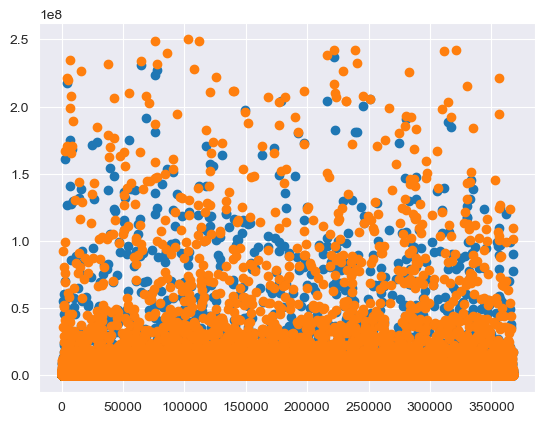

In [459]:
plt.scatter(np.arange(len(X_test)),np.exp(Y_pred2))
plt.scatter(np.arange(len(X_test)),np.exp(Y_test))

In [464]:
#best-performing model by far ^^

- **Model 3: Gradient Boosting Regression**

In [399]:
#train model
gbr = GradientBoostingRegressor()
gbr.fit(X_train, Y_train)

GradientBoostingRegressor()

In [400]:
# Make predictions on the testing set
y_pred3 = gbr.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(Y_test, y_pred3)

print("Root Mean Squared Error:", mse**(1/2))

Root Mean Squared Error: 0.8915490039145233
